Following [ResNet for MNIST with pytorch](https://www.kaggle.com/readilen/resnet-for-mnist-with-pytorch?scriptVersionId=6942243), using the MNIST dataset from torchvision.datasets instead of csv files.

### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

### Preparing dataset

In [2]:
# loading data
mnist_data = MNIST(root='../mnist/')

In [3]:
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../mnist/
    Split: Train

In [34]:
# seeing what dtype it returns
type(mnist_data)

torchvision.datasets.mnist.MNIST

In [4]:
# spliting data into x_data (features) and y_data(labels)
# normalizing x_data
x_data = mnist_data.data/255.
y_data = mnist_data.targets

In [8]:
# Spliting into train and test datasets. Size of train data is 85% and size of test data is 15%.
# random_state=42
features_train, features_test, targets_train, targets_test = train_test_split(x_data, y_data, test_size = 0.15, random_state = 42)

In [9]:
print(f'Features train size: {list(features_train.size())}')
print(f'Features test size: {list(features_test.size())}')
print(f'Targets train size: {list(targets_train.size())}')
print(f'Targets test size: {list(targets_test.size())}')

Features train size: [51000, 28, 28]
Features test size: [9000, 28, 28]
Targets train size: [51000]
Targets test size: [9000]


In [10]:
# seeing features dtype 
features_test.dtype

torch.float32

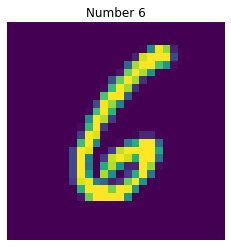

In [12]:
plt.imshow(features_train[12])
plt.axis("off")
plt.title("Number " + str(int(targets_train[12])))
plt.show() 

### Creating ResNet Model

In [24]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, 
                     out_channels, 
                     kernel_size=3, 
                     stride=stride, 
                     padding=1, 
                     bias=False)

<b><span style="color:blue">Study notes:</span></b><br>
[Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html) parameters:

- **in_channels (int)** – Number of channels in the input image
- **out_channels (int)** – Number of channels produced by the convolution
- **kernel_size (int or tuple)** – Size of the convolving kernel
- **stride (int or tuple, optional)** – Stride of the convolution. Default: 1
- **padding (int or tuple, optional)** – Zero-padding added to both sides of the input. Default: 0
- **padding_mode (string, optional)** – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'
- **dilation (int or tuple, optional)** – Spacing between kernel elements. Default: 1 
- **groups (int, optional)** – Number of blocked connections from input channels to output channels. Default: 1
- **bias (bool, optional)** – If True, adds a learnable bias to the output. Default: True

In this function, a 2d convolution is applied, the kernel size is 3x3 with initially a stride of 1 (can be specified a different value). There is a padding of 0s (1 pixel border).

In [98]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        
        return out

<b><span style="color:blue">Study notes:</span></b><br>

On [this medium article (Residual blocks — Building blocks of ResNet)](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec) there's a bit about what is a residual block.

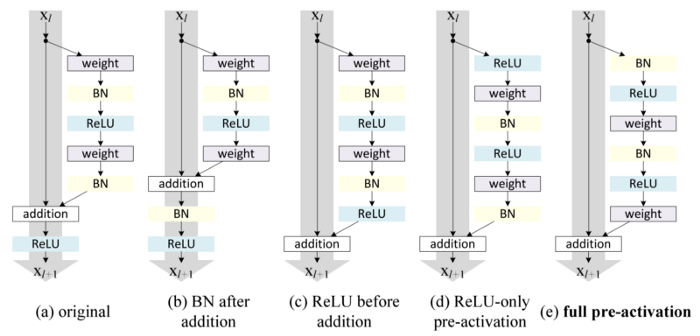
<center> Types of Residual Block. Source: <a href="https://towardsdatascience.cm/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec"> Residual blocks - Building blocks of ResNet </a></center>

In `__init__`:
- 3x3 convolution;
- [Batch normalization](https://arxiv.org/abs/1502.03167), size of out_channels and output is the same shape as input;
- Rectified linear unit function (operation in-place);
- 3x3 convolution, size of channels of input is the same as output channels size (produced by the convolution;
- Batch normalization;
- Downsample (uses nn.Sequential later on)

In [116]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)

    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

#### Testing layer funtions

In [117]:
# BatchNorm2d doc's example
m = nn.BatchNorm2d(100)
inputs = torch.randn(20, 100, 35, 45)
output = m(inputs)
output.shape

torch.Size([20, 100, 35, 45])

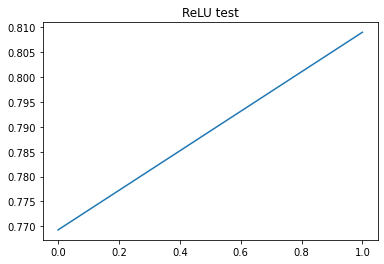

In [118]:
# ReLU doc's exemples

m = nn.ReLU()
inputs = torch.randn(2)
output = m(inputs)
plt.plot(output)
plt.title("ReLU test")
plt.show()

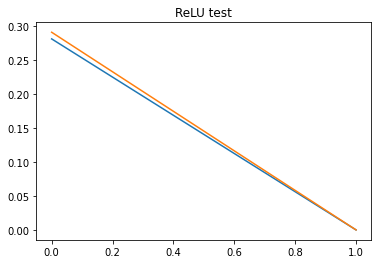

In [119]:
m = nn.ReLU()
inputs = torch.randn(2).unsqueeze(0)
output = torch.cat((m(inputs), m(-inputs)))
plt.plot(output)
plt.title("ReLU test")
plt.show()

### Training the Model

In [120]:
batch_size = 100
n_iters = 2500
num_epochs = n_iters/ (len(features_train) / batch_size)

In [121]:
num_epochs = int(num_epochs)
num_epochs

4

In [122]:
train = torch.utils.data.TensorDataset(features_train, targets_train)
test = torch.utils.data.TensorDataset(features_test, targets_test)

In [123]:
train

In [124]:
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle=False)

In [125]:
train_loader.sampler

In [126]:
train_loader.batch_size

100

In [127]:
train_loader.dataset

In [128]:
net_args = {
    "block": ResidualBlock,
    "layers": [2,2,2,2]
}

model = ResNet(**net_args)

In [129]:
error = nn.CrossEntropyLoss()

In [130]:
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [131]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

In [ ]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.resize_(batch_size, 1, 32, 32))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            correct = 0
            total = 0
            
            for images, labels in test_loader:
                images = Variable(images.resize_(batch_size, 1, 32, 32))
                outputs = model(images)
                
                predicted = torch.max(outputs.data, 1)[1]
                
                total += labels.size(0)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct/float(total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            print("Iteration: {}  Loss: {}  Accuracy: {} %".format(count, loss.data.item(), accuracy))

**First attempt: (had to interrupt kernel due to computer overheating)**

```
Iteration: 2250  Loss: 2.2994604110717773  Accuracy: 9.666666984558105 %
Iteration: 2500  Loss: 2.3086862564086914  Accuracy: 9.783333778381348 %
Iteration: 2750  Loss: 2.2945075035095215  Accuracy: 9.800000190734863 %
Iteration: 3000  Loss: 2.302509069442749  Accuracy: 10.824999809265137 %
Iteration: 3250  Loss: 2.3074557781219482  Accuracy: 10.158333778381348 %
Iteration: 3500  Loss: 2.30133056640625  Accuracy: 10.158333778381348 %
Iteration: 3750  Loss: 2.3018431663513184  Accuracy: 11.016666412353516 %
Iteration: 4000  Loss: 2.306149482727051  Accuracy: 11.016666412353516 %
Iteration: 4250  Loss: 2.3027260303497314  Accuracy: 10.824999809265137 %
Iteration: 4500  Loss: 2.3074378967285156  Accuracy: 11.016666412353516 %
Iteration: 4750  Loss: 2.296319007873535  Accuracy: 11.016666412353516 %
Iteration: 5000  Loss: 2.311678886413574  Accuracy: 10.158333778381348 %
Iteration: 5250  Loss: 2.293056011199951  Accuracy: 9.791666984558105 %
Iteration: 5500  Loss: 2.302060127258301  Accuracy: 10.824999809265137 %
Iteration: 5750  Loss: 2.307410955429077  Accuracy: 11.016666412353516 %
Iteration: 6000  Loss: 2.304231643676758  Accuracy: 9.791666984558105 %
Iteration: 6250  Loss: 2.318359613418579  Accuracy: 11.016666412353516 %
Iteration: 6500  Loss: 2.314941167831421  Accuracy: 9.800000190734863 %
Iteration: 6750  Loss: 2.2943100929260254  Accuracy: 11.016666412353516 %
Iteration: 7000  Loss: 2.282406806945801  Accuracy: 9.666666984558105 %
Iteration: 7250  Loss: 2.2960901260375977  Accuracy: 10.824999809265137 %
Iteration: 7500  Loss: 2.3232717514038086  Accuracy: 11.016666412353516 %
Iteration: 7750  Loss: 2.2987711429595947  Accuracy: 9.666666984558105 %
Iteration: 8000  Loss: 2.295541286468506  Accuracy: 9.666666984558105 %
Iteration: 8250  Loss: 2.3052279949188232  Accuracy: 11.016666412353516 %
```